# Project Title: USA Real Estate Exploration

Project Description: Real Estate listings in the US broken by State and zip code https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset

# Import Modules

In [1]:
import os
import pyspark
import warnings
import pandas as pd
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from urllib.request import urlopen
from pyspark.sql import SparkSession

# Options and Settings

In [2]:
warnings.simplefilter('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load Image

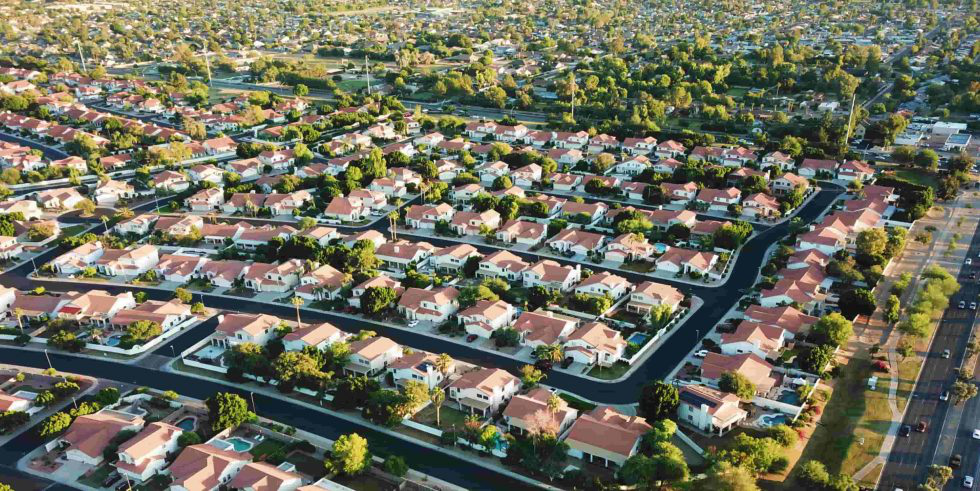

In [3]:
image_url = 'https://assets.thewanderinginvestor.com/wp-content/uploads/20200913005157/suburbs-980x491.jpg'
Image.open(urlopen(image_url))

# Create Spark Session

In [4]:
spark = SparkSession.builder.master('local').appName('USA Real Estate').getOrCreate()
print(f'The PySpark {spark.version} version is running....')

The PySpark 3.3.2 version is running....


# Download Data

In [5]:
! kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

df = pd.read_csv('usa-real-estate-dataset.zip')

usa-real-estate-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


# Convert Pandas to PySpark DataFrame

In [6]:
spark.conf.set('spark.sql.execution.arrow.enabled','true')
df_spark = spark.createDataFrame(df)
df_spark.printSchema()

root
 |-- status: string (nullable = true)
 |-- bed: double (nullable = true)
 |-- bath: double (nullable = true)
 |-- acre_lot: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: double (nullable = true)
 |-- house_size: double (nullable = true)
 |-- prev_sold_date: string (nullable = true)
 |-- price: double (nullable = true)



# Create a global temporary view

In [7]:
df_spark.createOrReplaceGlobalTempView('usa_housing')

# Queries

Returns Top 10 States With the Highest Count

In [8]:
query1 = '''
          select 
                distinct 
                        uh.state, 
                        count(*) as state_count
          from global_temp.usa_housing uh
          group by 1
          order by 2 desc

         '''

spark.sql(query1).show(10)

+--------------+-----------+
|         state|state_count|
+--------------+-----------+
| Massachusetts|     170368|
| New Hampshire|      46740|
|  Rhode Island|      28518|
|   Puerto Rico|      24679|
|   Connecticut|      14610|
|         Maine|      12687|
|       Vermont|       3801|
|Virgin Islands|       2573|
|      New York|       1955|
|South Carolina|         24|
+--------------+-----------+
only showing top 10 rows



Returns All Table Information

In [9]:
query2 = '''
          select 
                distinct 
                        * 
          from global_temp.usa_housing

         '''

spark.sql(query2).show(10)

+--------+----+----+--------+-----------+-----------+--------+----------+--------------+---------+
|  status| bed|bath|acre_lot|       city|      state|zip_code|house_size|prev_sold_date|    price|
+--------+----+----+--------+-----------+-----------+--------+----------+--------------+---------+
|for_sale|null|null|    2.82|  Cabo Rojo|Puerto Rico|   623.0|      null|          null| 120000.0|
|for_sale|null|null|    0.47|      Camuy|Puerto Rico|   627.0|      null|          null| 105000.0|
|for_sale| 3.0| 3.0|    null|     Dorado|Puerto Rico|   646.0|    1983.0|          null|1200000.0|
|for_sale| 3.0| 1.0|    0.22|   Mayaguez|Puerto Rico|   680.0|     746.0|          null|  35000.0|
|for_sale|null|null|    0.08|      Ponce|Puerto Rico|   715.0|      null|          null|  37000.0|
|for_sale| 2.0| 2.0|    null|   Guaynabo|Puerto Rico|   969.0|     954.0|          null| 103000.0|
|for_sale| 3.0| 2.0|    0.09|     Caguas|Puerto Rico|   725.0|    1000.0|          null| 126000.0|
|for_sale|

Returns House Status By State

In [10]:
query3 = '''
         select 
               distinct 
                       uh.state,
                       uh.status,
                       count(uh.status) as status_count
         from global_temp.usa_housing uh
         group by 1, 2
         order by 3 desc

         '''

spark.sql(query3).show()

+--------------+--------------+------------+
|         state|        status|status_count|
+--------------+--------------+------------+
| Massachusetts|      for_sale|      169608|
| New Hampshire|      for_sale|       46740|
|  Rhode Island|      for_sale|       28518|
|   Puerto Rico|      for_sale|       24679|
|   Connecticut|      for_sale|       14610|
|         Maine|      for_sale|       12687|
|       Vermont|      for_sale|        3801|
|Virgin Islands|      for_sale|        2573|
|      New York|      for_sale|        1955|
| Massachusetts|ready_to_build|         760|
|South Carolina|      for_sale|          24|
|      Virginia|      for_sale|          20|
|     Tennessee|      for_sale|          20|
|       Wyoming|      for_sale|           3|
|    New Jersey|      for_sale|           2|
+--------------+--------------+------------+



Returns Top 10 Cities With The Highest Acre Lot

In [11]:
query4 = '''
         with
              cte1 as (
                        select 
                             distinct 
                                     uh.city,
                                     uh.state,
                                     uh.acre_lot,
                                     round(avg(uh.acre_lot) over w) as avg_acre_lot,
                                     date(uh.prev_sold_date) as prev_sold_date
                        from global_temp.usa_housing uh
                        window w as ()
                      )
          select distinct state, city, acre_lot, prev_sold_date
          from cte1
          where acre_lot >= avg_acre_lot
          order by acre_lot desc
          limit 10          

         '''

spark.sql(query4).show()

+--------------+----------------+--------+--------------+
|         state|            city|acre_lot|prev_sold_date|
+--------------+----------------+--------+--------------+
|   Puerto Rico|        San Juan|100000.0|          null|
|   Connecticut|        Simsbury| 99999.0|          null|
|   Connecticut|      Middletown| 99999.0|          null|
|  Rhode Island|    Narragansett| 18817.0|    2020-09-14|
|         Maine|        Portland| 13697.0|          null|
| Massachusetts|Mount Washington|  9035.0|          null|
|      New York|   Hoosick Falls|  6680.0|          null|
|         Maine|        Portland|  4500.0|          null|
|Virgin Islands|   Christiansted| 3600.11|          null|
|   Puerto Rico|           Ponce|  2960.0|          null|
+--------------+----------------+--------+--------------+



In [12]:
query5 = '''
         select city, price
         from (
               select 
                     distinct
                             uh.state,
                             uh.city,
                             uh.house_size,
                             round(avg(uh.house_size) over w) as avg_house_size,
                             round(avg(uh.price) over w) as avg_price,
                             uh.price
               from global_temp.usa_housing uh
               window w as (partition by uh.state, uh.city)
              ) as sub_tbl
        where house_size > avg_house_size and price > avg_price

         '''

spark.sql(query5).show()

+-------+---------+
|   city|    price|
+-------+---------+
|Andover| 400000.0|
|Ashford| 640000.0|
|Ashford| 499900.0|
|Ashford| 399900.0|
|   Avon|1250000.0|
|   Avon|1395000.0|
|   Avon|5995000.0|
|   Avon| 630000.0|
|   Avon| 699900.0|
|   Avon|1199000.0|
|   Avon|1200000.0|
|   Avon| 829900.0|
|   Avon|1750000.0|
|   Avon|1195000.0|
|   Avon| 699999.0|
|   Avon|2849900.0|
|   Avon| 929995.0|
|   Avon| 819900.0|
|   Avon| 699900.0|
|   Avon|1200000.0|
+-------+---------+
only showing top 20 rows

